<h2><center>LAB Air Pollution</center></h2> 

The low quality of air, especially high concentration of particulate matter that have significant negative effect on human health and environment, is a global problem in urban areas. Thus, early air pollution prediction is an urgent need in Skopje, North Macedonia with highly increased concentration of particulate matter especially during the winter months.

Researchers from different areas have explored various models for predicting air pollution using professional knowledge and experience in that field, but these models can be in general defined as: empirical models, fuzzy logic-based models, simulation models based on meteorological data and methods and in recent time, data-driven machine learning models.

In this notebook, a machine learning apporach is demonstrated, with all the necessery steps that need to be considered in order to get good model performance, such as: data preparation, feature extraction and selection, regression learning with hyperparameters optimization.

The data we are going to use consists of air pollution data obtained from sensors mounted in Municipality of Karpos, near the Faculty of Electrical Engineering and Information Technologies, as well as meteorological data for the respective locations gathered from the open API provided by DarkSky for cities and municipalities across the world, in this case from Republic of North Macedonia. The obtained air pollution data is of two periods, from May 2018 to October 2018, and from December 2018 to March 2019.

Here is a link to download the pollution and meteorological datasets that we are going to use within this notebook:

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's define a function that reads a CSV file to pandas DataFrame and converts the timestamps into datetime objects if needed. The CSV file must contain a column with either a UNIX timestamp or a datetime string with any format supported by Pandas. 

Parameters:

-path : path to CSV file

-ts : name of the column containing time data, "time" by default
Returns:

-df : Pandas Series object with datetime as index

In [2]:
def read_csv_series(path, ts="time"):
    # read CSV
    df = pd.read_csv(path, parse_dates=[ts])
    # convert timestamps to datetime objects using panda's to_datetime
    df[ts] = pd.to_datetime(df[ts], unit="s")
    # set datetime as index (make time series)
    df.index = df[ts]
    # delete original time column
    del df[ts]

    # remove rows with duplicated time if there are any, keep first duplicate row
    df = df.loc[~df.index.duplicated(keep="first")]

    df.index.name = ts

    return df

The function 'describe_series' shows basic information about a Pandas Series or DataFrame.
Parameters:
-df: a Pandas Series or DataFrame object

In [3]:
def describe_series(df):
    print("Head:")
    print(df.head())
    print("Stats:")
    print(df.describe())
    print("Count:")
    print(df.count())
    print("Columns: {}".format(df.columns))
    print("Start of time: {}".format(str(df.index[0])))
    print("End of time: {}".format(str(df.index[-1])))

## Preprocessing Pollution Report

In [4]:
# use helper function to read pollution time series
df = read_csv_series("apdata/pollutionData.csv")
describe_series(df)

Head:
                         PM10
time                         
2018-05-17 14:00:00  2.848039
2018-05-17 15:00:00  3.230097
2018-05-17 16:00:00  4.627381
2018-05-17 17:00:00  5.518269
2018-05-17 18:00:00  7.292308
Stats:
              PM10
count  4470.000000
mean     25.607856
std      38.195382
min       0.639048
25%       6.643693
50%       9.757045
75%      24.780238
max     391.371429
Count:
PM10    4470
dtype: int64
Columns: Index(['PM10'], dtype='object')
Start of time: 2018-05-17 14:00:00
End of time: 2019-02-19 15:00:00


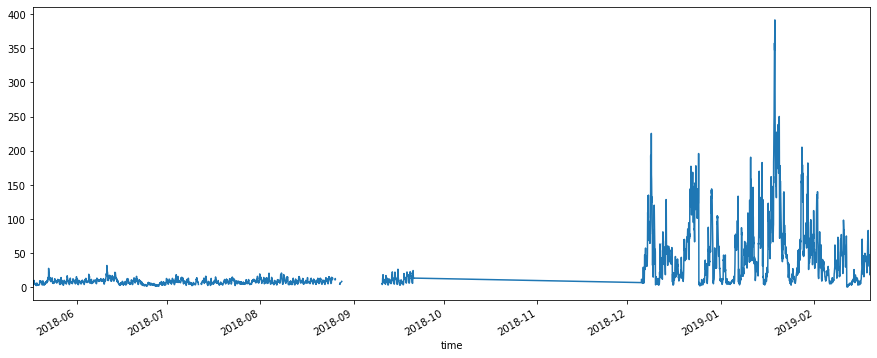

In [5]:
# convert series values to numeric type (np.float64 by default)
# place NaN values in rows with invalid format
df = pd.to_numeric(df["PM10"], errors="coerce")

# plot the complete PM10 time series
plt.figure(figsize=(15, 6))
df.plot()
plt.show()

From the time series plots it can be seen that there are periods where there is no data. We cannot interpolate such a large period of time, so we can safely remove it from our dataset.

First, we will reindex the series for the complete time period, from start to end, in order to see how much data we are actually missing. So, not only will we account for rows in which the value is NaN, but we will also add rows with NaN values for missing timestamps.

In [6]:
# create a new datetime index with hourly frequency
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
idx_name = df.index.name
# reindex our series
df = df.reindex(idx)
df.index.name = idx_name
print("Total rows: {}".format(len(df)))
print("Number of NaN rows: {}".format(df.isna().sum()))

# if data is missing for more than 1 hour, remove those rows
# otherwise, interpolate
df = df.interpolate(method="linear", limit=4, limit_area="inside")
df = df.dropna()
print("Number of rows after interpolation: {}".format(len(df)))

Total rows: 6674
Number of NaN rows: 2204
Number of rows after interpolation: 4523


Another thing to notice from the plots is that in some periods the sensor measurements extend way beyond the next highest measured value. We can assume that this is due to a sensor fault and the measured values are invalid, but anyways we need to remove/interpolate these values because they might be a cause for bad model performance later.

Also, we can also set to NaN and then interpolate or remove negative values for PM10 since it is obvious that they are invalid.

In [7]:
# assign NaNs to values greater than 500 or negative and interpolate/drop again
df.loc[(df > 500) | (df < 0)] = np.nan
df = df.interpolate(method="linear", limit=4, limit_area="inside")
df = df.dropna()
print("Number of rows after outlier removal: {}".format(len(df)))

Number of rows after outlier removal: 4523


At this point we need to re-evaluate the dataset to see how it transformed.

count    4523.000000
mean       25.418662
std        38.011904
min         0.639048
25%         6.666879
50%         9.744000
75%        24.004771
max       391.371429
Name: PM10, dtype: float64


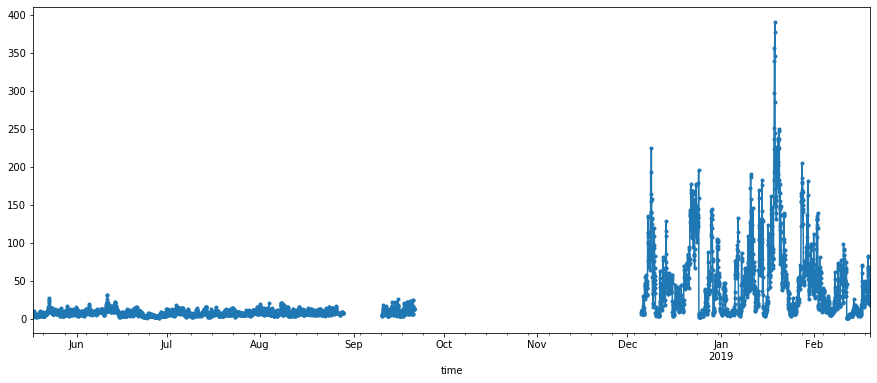

In [8]:
print(df.describe())
# plot the PM10 time series
plt.figure(figsize=(15, 6))
df.reindex(idx).plot(marker=".")
plt.show()

## Preprocessing Weather Report

Head:
                     apparentTemperature  cloudCover  dewPoint  humidity  \
time                                                                       
2014-12-31 23:00:00                 9.03        0.44      5.03      0.58   
2015-01-01 00:00:00                 9.03        0.44      5.03      0.58   
2015-01-01 01:00:00                 4.87        0.44      3.24      0.57   
2015-01-01 02:00:00                 3.62        0.44      3.24      0.62   
2015-01-01 03:00:00                 5.83        0.44      3.24      0.57   

                                    icon  ozone  precipAccumulation  \
time                                                                  
2014-12-31 23:00:00  partly-cloudy-night    NaN                 NaN   
2015-01-01 00:00:00  partly-cloudy-night    NaN                 NaN   
2015-01-01 01:00:00  partly-cloudy-night    NaN                 NaN   
2015-01-01 02:00:00  partly-cloudy-night    NaN                 NaN   
2015-01-01 03:00:00  partly-cloudy-

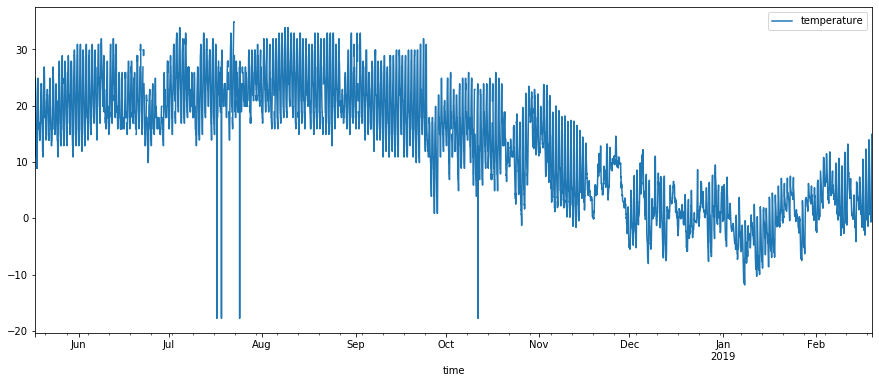

In [9]:
# use helper function to read weather time series
# df = read_csv_series("../data/raw/weather/weather_centar.csv")
df = read_csv_series("apdata/meteorologicalData.csv")
describe_series(df)

# plot the temperature time series
df.reindex(idx).plot(y=["temperature"], figsize=(15, 6))

In [10]:
# check for gaps in series
# create a new datetime index with hourly frequency
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
idx_name = df.index.name
# reindex our series
df = df.reindex(idx)
df.index.name = idx_name
print("Total rows: {}".format(len(df)))
print("Number of NaN rows: \n{}".format(df.isna().sum()))

Total rows: 45480
Number of NaN rows: 
apparentTemperature       35
cloudCover              9496
dewPoint                  31
humidity                  35
icon                      31
ozone                  33331
precipAccumulation     45235
precipIntensity         3744
precipProbability       3744
precipType             37226
pressure               23515
summary                   31
temperature               31
uvIndex                 4352
visibility                61
windBearing             8064
windGust               23861
windSpeed                149
dtype: int64


We will replace NaN with 0 for cloudCover and interpolate pressure with a limit of 7 hours.
We don't need precipType, precipAccumulation and ozone columns, as there are mostly NaN values, so we will drop it.
The rest of the data is left untouched.

In [11]:
df = df.drop(["windGust"], axis=1)
df = df.drop(["uvIndex"], axis=1)
df = df.drop(["precipIntensity"], axis=1)
df = df.drop(["precipProbability"], axis=1)
df = df.drop(["pressure"], axis=1)
df = df.drop(["precipType"], axis=1)
df = df.drop(["precipAccumulation"], axis=1)
df = df.drop(["ozone"], axis=1)
df = df.fillna({'cloudCover': 0})
df["apparentTemperature"].interpolate(inplace=True, limit=5)
df = df.dropna()

In [12]:
# check for columns with discrete values, one-hot encode them
categorical_column_names = list(df.select_dtypes(include=['object']).columns)
# cannot one-hot encode NaN values
for column_name in categorical_column_names:
    one_hot = pd.get_dummies(df[column_name])
    df = df.join(one_hot, lsuffix='_left', rsuffix='_right')

df = df.drop(categorical_column_names, axis=1)
# pd.DataFrame(df).to_csv("apdata/Centar.csv")

## Join Pollution and Weather Datasets

In [13]:
df_pollution = read_csv_series("apdata/pollutionData.csv")

df=df_pollution.merge(df, on='time')
describe_series(df)
# df.dropna(subset=["PM10"])
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
# df.reindex(idx).plot(y=["PM10", "temperature"], figsize=(15, 6))
df.drop('Partly Cloudy', axis=1)
df=df.dropna()
pd.DataFrame(df).to_csv("apdata/combined.csv")

Head:
                         PM10  apparentTemperature  cloudCover  dewPoint  \
time                                                                       
2018-05-17 14:00:00  2.848039                76.79        0.19     48.20   
2018-05-17 15:00:00  3.230097                76.58        0.38     49.76   
2018-05-17 16:00:00  4.627381                74.99        0.19     49.99   
2018-05-17 17:00:00  5.518269                73.18        0.19     49.99   
2018-05-17 18:00:00  7.292308                69.58        0.22     49.25   

                     humidity  temperature  visibility  windBearing  \
time                                                                  
2018-05-17 14:00:00      0.37    24.883333       6.216        161.0   
2018-05-17 15:00:00      0.39    24.766667       6.216        110.0   
2018-05-17 16:00:00      0.41    23.883333       6.216        350.0   
2018-05-17 17:00:00      0.44    22.877778       6.216         11.0   
2018-05-17 18:00:00      0.48    20

PermissionError: [Errno 13] Permission denied: 'apdata/combined.csv'

Now we are going to extract cyclical features for the time-related features: hours of the day, days of the week, months in a year. It is important to perform this transformation of the cyclical features in order to better represent the cyclical phenomenon, e.g., to avoid the artificial large difference between the 23:00 and 00:00 hour. The best way to handle this is to calculate the sin() and cos() component so that this cyclical feature is represented as (𝑥,𝑦) coordinates of a circle. In this representation hour, 23 and hour 0 are right next to each other numerically, just as they should be.

In [ ]:
# df.set_index('time', inplace=True)
df['h'] = df.index.hour
df['m'] = df.index.month
df['doy']= df.index.dayofyear
df['woy']= df.index.weekofyear
df['dow']= df.index.dayofweek
brzpi=2*np.pi

df['hcos']=np.around(np.cos(df['h']*(brzpi/24)),5)
df['hsin']=np.around(np.sin(df['h']*(brzpi/24)),5)

df['mcos']=np.around(np.cos(df['h']*(brzpi/12)),5)
df['msin']=np.around(np.sin(df['h']*(brzpi/12)),5)

df['doycos']=np.around(np.cos(df['doy']*(brzpi/365)),12)
df['doysin']=np.around(np.sin(df['doy']*(brzpi/365)),12)

df['woycos']=np.around(np.cos(df['woy']*(brzpi/52)),7)
df['woysin']=np.around(np.sin(df['woy']*(brzpi/52)),7)

df['dowcos']=np.around(np.cos(df['dow']*(brzpi/7)),5)
df['dowsin']=np.around(np.sin(df['dow']*(brzpi/7)),5)

Using the code below, we will try to predict the PM10 concetration using KN Regressor. The performance of the model is evaluated based on three metrics: Mean Absolute Error, Mean Squared Error and Root Mean Squared Error.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

#X, y = df.iloc[:,:-1],df.iloc[:,-1]
X, y = df.loc[:, df.columns != 'PM10'], df['PM10']

poczima=2054
desposzim=np.floor(0.1*3879)
desposlet=desposzim
# dodatok=0.1*3879
# zim=2054
# dolz=3879
# dolz=np.floor(dolz*0.1)
# X_train=[0:(2054-dodatok)]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# X_test=X.drop([round(poczima-desposzim),round(poczima+desposzim)])
# y_test=y.drop([round(poczima-desposzim),round(poczima+desposzim)])
# X_train=X
# y_train=y

print(X.iloc(poczima-desposzim,poczima+desposzim))
X_train=X.drop([poczima-desposzim,poczima+desposlet])
y_train=y.drop([poczima-desposzim,poczima+desposlet])



X_test=X[poczima-desposzim:poczima+desposlet][:]
y_test=y[poczima-desposzim:poczima+desposlet][:]



model= KNeighborsRegressor()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

## TODO:
Try using different regression models or changing the hyperparameters with purpose to improve the results.

In the next cell, the code plots the actual and predicted values of the PM10 concentration.

In [ ]:
import datetime
df['y'] = df.index.year
df['d'] = df.index.day
m=df['m']
god=df['y']
d=df['d']
h=df['h']
m=m.tolist()
god=god.tolist()
d=d.tolist()
h=h.tolist()
dates = [str(int(year)) + '-' + str(int(month))+ '-' + str(int(day)) + ' ' +str(int(hour)) +':00' for year, month, day, hour in zip(god, m, d, h)]
#print(dates)
dates = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M') for date in dates]
true_data = pd.DataFrame(data = {'date': dates, 'actual': y_test})
true_data2= true_data 
true_data['date'] = pd.to_datetime(true_data['date'])
true_data = true_data.set_index('date')
true_data = true_data.resample('H').asfreq()
predictions_data = pd.DataFrame(data = {'date': dates, 'prediction': y_pred}) 
predictions_data2=predictions_data
predictions_data['date'] = pd.to_datetime(predictions_data['date'])
predictions_data = predictions_data.set_index('date')
predictions_data = predictions_data.resample('H').asfreq()
dl=true_data.dropna().index.date.tolist()
r=len(dl)
l=8
kl=[dl[int(np.floor(0*r/l))],dl[int(np.floor(0*r/l))],dl[int(np.floor(1*r/l))],dl[int(np.floor(2*r/l))],dl[int(np.floor(3*r/l))],dl[int(np.floor(4*r/l))],dl[int(np.floor(5*r/l))],dl[int(np.floor(6*r/l))],dl[int(np.floor(7*r/l))]];
fig, ax = plt.subplots()
ax.plot(range(true_data['actual'].dropna().size), true_data['actual'].dropna())
ax.set_xticklabels(kl);
fig.autofmt_xdate()
ax.plot(range(predictions_data['prediction'].dropna().size), predictions_data['prediction'].dropna())
ax.set_xticklabels(kl);
fig.autofmt_xdate()
plt.show()
fig, ax = plt.subplots()
ax.plot(range(true_data['actual'].dropna().size), true_data['actual'].dropna())
ax.set_xticklabels(kl);
fig.autofmt_xdate()
ax.plot(range(predictions_data['prediction'].dropna().size), predictions_data['prediction'].dropna())
ax.set_xticklabels(kl);
fig.autofmt_xdate()
ax.set_yscale('log')
plt.show()

## TODO:
Have a look at the graph: is the error stable, is it following the trend of the pollution?

Using the function 'plot_importance()', we will get a diagram showing the importance of the features to the chosen model, starting from the most important and finishing with the least important one.

In [ ]:
plot_importance(model)

## TODO:
Write the 3 most important features and discuss their impact on the air pollution level.

When doing this kind of analysis, for the sake of clarity, it is important to have at least a few most important features plotted in a readable form. For example, a contour or vector plot or any other spatial plot.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

w=X['windSpeed']
w=np.clip(w,0,10)
t=X['temperature']
t=np.clip(t,-10,40)
p=y
p=np.clip(p,0,100)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(w, t, p, linewidth=0.2, antialiased=True, cmap=plt.cm.gist_rainbow)
plt.ylabel("Temperature [°C]")
plt.xlabel("Wind [m/s]")
plt.zlabel("PM10 [ppm]")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## TODO: 
Discuss the dependences between the concetration of the PM10 particles and wind speed and temperature. What can you conclude from the 3D plot?